<Axes: xlabel='tmax', ylabel='tmax_tomorrow'>

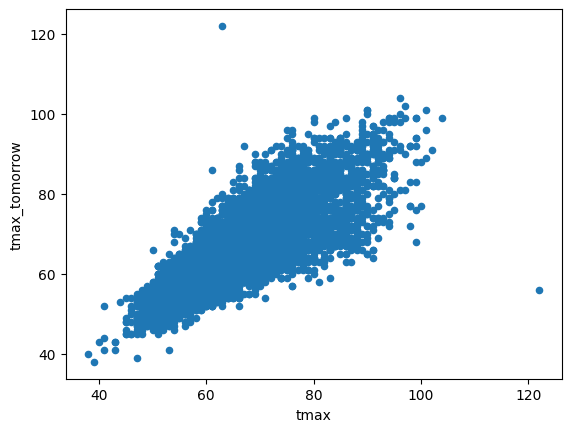

In [4]:
import pandas as pd

data = pd.read_csv("/content/clean_weather.csv", index_col=0)
data = data.ffill()

data.plot.scatter("tmax", "tmax_tomorrow")

In [5]:
data.corr()

,tmax,tmin,rain,tmax_tomorrow
tmax,1.000000,0.615604,-0.219941,0.818561
tmin,0.615604,1.000000,-0.019546,0.585572
rain,-0.219941,-0.019546,1.000000,-0.211799
tmax_tomorrow,0.818561,0.585572,-0.211799,1.000000


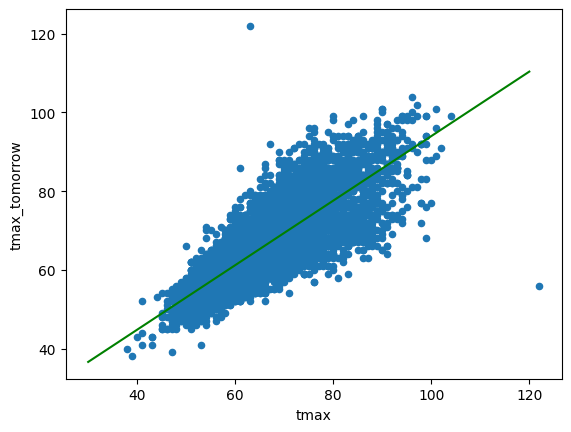

In [6]:
import matplotlib.pyplot as plt

data.plot.scatter("tmax", "tmax_tomorrow")

prediction = lambda x, wl=.82, b=11.99: x * wl +b
plt.plot([30, 120], [prediction(30), prediction(120)], 'green')


In [7]:
import numpy as np

def mse(actual, predicted):
    return np.mean((actual - predicted) ** 2)

print(mse(data["tmax_tomorrow"], prediction(data["tmax"])))
print(mse(data["tmax_tomorrow"], prediction(data["tmax"], .82, 13)))

22.897335324598416
24.118285439336727


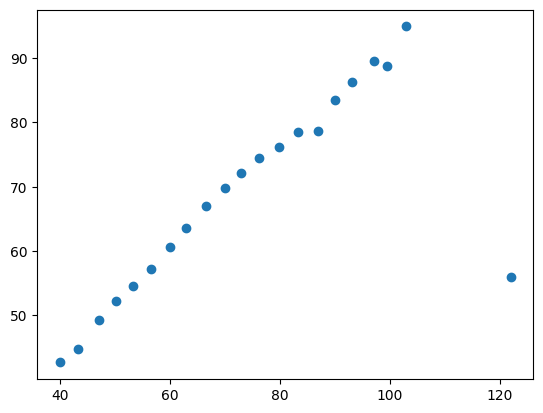

In [8]:
tmax_bins = pd.cut(data["tmax"], 25)

ratios = (data["tmax_tomorrow"] - 11.99 / data["tmax"])
binned_ratio = ratios.groupby(tmax_bins).mean()
binned_tmax = data["tmax"].groupby(tmax_bins).mean()
plt.scatter(binned_tmax, binned_ratio)

A nonlinear transformation on top of the linear transformation.
Multiple layers, which can capture interactions between features.
Multiple hidden units, which each have slightly differenct linear and nonlinear transformation.

$y = wx +b$

$y = relu(wx +b)$

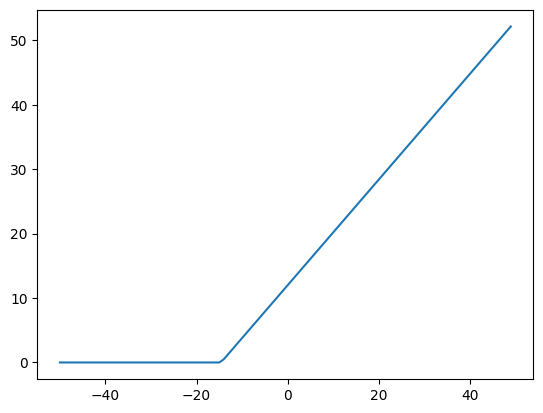

In [9]:
temps = np.arange(-50, 50)
plt.plot(temps, np.maximum(0, prediction(temps)))

$\hat{y} = w_{2} relu(w_{1}x +b_{1}) + b_{2}$

(0.0, 40.0)

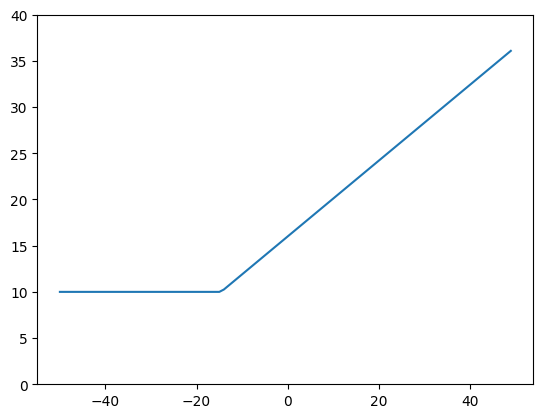

In [10]:
temps = np.arange(-50, 50)

layer1 = np.maximum(0, prediction(temps))
layer2 = prediction(layer1, .5, 10)

plt.plot(temps, layer2)
plt.ylim((0, 40))

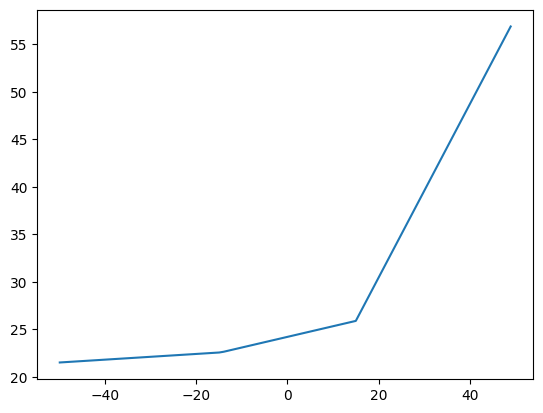

In [11]:
layer1_1 = np.maximum(0, prediction(temps))
layer1_2 = np.maximum(0, prediction(temps, .1, 10))
layer1_3 = np.maximum(0, prediction(temps, 2, -30))

layer2 = layer1_1 * 0.1 + layer1_2 * .3 + layer1_3 * 0.4 +20
plt.plot(temps, layer2)


In [12]:
!pip install tensor-sensor
import tsensor

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.4 MB/s eta 0:00:00
  Created wheel for tensor-sensor: filename=tensor_sensor-1.0-py3-none-any.whl size=26895 sha256=f8e3279260b20dc1a6e01879cd00c68d448f07320a55c451719a4bc1154a6046
  Stored in directory: /root/.cache/pip/wheels/cc/56/c8/0c0e7d4ea1b23ae2935bb71ab39b4c1af9f71d4287f6566ecd
Successfully built tensor-sensor


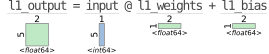

array([[77.59, 18.  ],
       [85.79, 19.  ],
       [93.99, 20.  ],
       [-4.41,  8.  ],
       [ 3.79,  9.  ]])

In [38]:
input = np.array([[80], [90], [100], [-20], [-10]])

l1_weights = np.array([[.82, .1]])
l1_bias = np.array([[11.99, 10]])

with tsensor.explain():
    l1_output = input @ l1_weights + l1_bias

l1_output

In [14]:
l1_activated = np.maximum(l1_output, 0)
l1_activated

array([[77.59, 18.  ],
       [85.79, 19.  ],
       [93.99, 20.  ],
       [ 0.  ,  8.  ],
       [ 3.79,  9.  ]])

$layer_{1} = relu(XW_{1} + B_{1})$

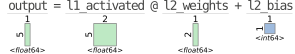

array([[47.395],
       [51.695],
       [55.995],
       [ 6.6  ],
       [ 8.695]])

In [15]:
l2_weights = np.array([
    [.5], [.2]
])
l2_bias = np.array([[5]])

with tsensor.explain():
  output = l1_activated @ l2_weights + l2_bias

output

In [16]:
tmax = np.array([[80], [90], [100], [-20], [-10]])
tmax_tomorrow = np.array([[83], [89], [95], [-22], [-9]])

In [17]:
def mse(actual, predicted):
  return (actual - predicted) **2

mse(tmax_tomorrow, output)

array([[1267.716025],
       [1391.663025],
       [1521.390025],
       [ 817.96    ],
       [ 313.113025]])

In [18]:
def mse_grad(actual, predicted):
  return predicted - actual

mse_grad(tmax_tomorrow, output)

array([[-35.605],
       [-37.305],
       [-39.005],
       [ 28.6  ],
       [ 17.695]])

In [19]:
output_gradient = mse_grad(tmax_tomorrow, output)

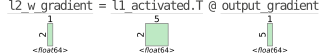

array([[-9562.0038],
       [-1741.73  ]])

In [20]:
from tsensor import explain as exp

with exp():
  l2_w_gradient = l1_activated.T @ output_gradient

l2_w_gradient

In [21]:
from sympy import diff, symbols

x, w = symbols('X, W')
sympy_output = x * w
diff(sympy_output, w)


X

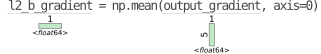

array([-13.124])

In [22]:
with exp():
  l2_b_gradient = np.mean(output_gradient, axis=0)

l2_b_gradient

In [23]:
l2_weights

array([[0.5],
       [0.2]])

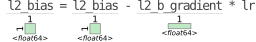

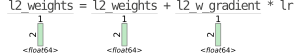

array([[0.30875992],
       [0.1651654 ]])

In [26]:
lr = 1e-5

with exp():
  l2_bias = l2_bias - l2_b_gradient * lr
  l2_weights = l2_weights + l2_w_gradient * lr

l2_weights

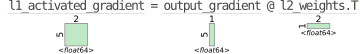

array([[-10.99339709,  -5.88071407],
       [-11.51828896,  -6.16149525],
       [-12.04318084,  -6.44227643],
       [  8.83053383,   4.72373044],
       [  5.46350686,   2.92260175]])

In [32]:
with exp():
  l1_activated_gradient = output_gradient @ l2_weights.T

l1_activated_gradient

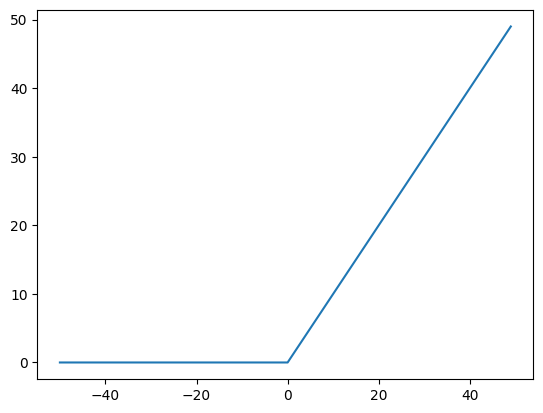

In [29]:
temps = np.arange(-50, 50)

plt.plot(temps, np.maximum(0, temps))

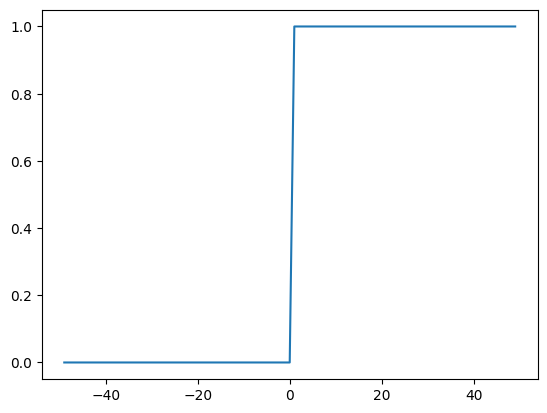

In [30]:
activation = np.maximum(0, temps)

plt.plot(temps[1:], activation[1:] - np.roll(activation, 1)[1:])

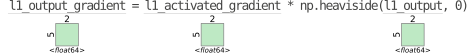

array([[-10.99339709,  -5.88071407],
       [-11.51828896,  -6.16149525],
       [-12.04318084,  -6.44227643],
       [  0.        ,   4.72373044],
       [  5.46350686,   2.92260175]])

In [33]:
with exp():
  l1_output_gradient = l1_activated_gradient * np.heaviside(l1_output, 0)

l1_output_gradient

In [39]:
from sympy.simplify.fu import L
l1_w_gradient = input.T @ l1_output_gradient
l1_b_gradient = np.mean(l1_output_gradient, axis=0)

l1_weights -= l1_w_gradient *lr
l1_bias -= l1_b_gradient * lr


In [40]:
l1_weights

array([[0.85175071, 0.1179292 ]])

In [41]:
l1_bias

array([[11.99005818, 10.00002168]])

1. Run the network forward pass, and get the output.
2. Compute gradient with respect to the output of network. (the mse_grad function)
3. For each layer in the network:
- Compute the gradient with respect to the pre nonlinearity output (if the layer has a nonlinearity)
- Compute the gradient with respect to the weights
- Compute the gradient with respect to the biases
- Compute the gradient with respect to the input to the layer
4. Update the parameters in the network using gradient descent.

In [42]:
import numpy as np
from sklearn.preprocessing import StandardScaler

predictors = ["tmax", "tmin", "rain"]
target = "tmax_tomorrow"

scaler = StandardScaler()
data[predictors] = scaler.fit_transform(data[predictors])

split_data = np.split(data, [int(.7 * len(data)), int(.85 * len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[d[predictors].to_numpy(), d[[target]].to_numpy()]
                                                            for d in split_data]

In [44]:
def init_layers(inputs):
  layers = []
  for i in range(1, len(inputs)):
    layers.append([
        np.random.rand(inputs[i-1], inputs[1]) / 5 - .1,
                       np.ones((1, inputs[i]))
    ])
    return layers

layer_conf = [3, 10, 10 , 1]
layers = init_layers(layer_conf)

In [45]:
def forward(batch, layers):
  hiddens = [batch.copy()]
  for i in range(len(layers)):
    batch = np.matmul(batch, layers[i][0]) + layers[i][1]
    if i < len(layers) - 1:
      batch = np.maximum(batch, 0)
    hiddens.append(batch.copy())
  return batch, hiddens

In [54]:
def mse(actual, predicted):
  return (actual - predicted) **2

def mse_grad(actual, predicted):
  return predicted - actual

In [59]:
def backward(layers, hidden, grad, lr):
  for i in range(len(layers)-1, -1, -1):
    if i != len(layers) - 1:
      grad = np.multiply(grad, np.heaviside(hidden[i+1], 0))

    w_grad = hidden[i].T @ grad
    b_grad = np.mean(grad, axis=0)
    layers[i][0] -= w_grad * lr
    layers[i][1] -= b_grad * lr
    grad = grad @ layers[i][0].T

  return layers

In [62]:
lr = 1e-6

epochs = 10
batch_size = 8

layers = init_layers(layer_conf)

for epoch in range(epochs):
  epoch_loss = 0

  for i in range(0, train_x.shape[0], batch_size):
    x_batch = train_x[i:(i+batch_size)]
    y_batch = train_y[i:(i+batch_size)]

    pred, hidden = forward(x_batch, layers)

    loss = mse_grad(y_batch, pred)
    epoch_loss += np.mean(loss ** 2)

    layers = backward(layers, hidden, loss, lr)

  valid_preds, _ = forward(valid_x, layers)

  print(f"Epoch {epoch} Train MSE: {epoch_loss / (train_x.shape[0] / batch_size)} Valid MSE: {np.mean(mse(valid_preds, valid_y))}")

Epoch 0 Train MSE: 4196.8032603929105 Valid MSE: 4448.360114428051
Epoch 1 Train MSE: 4186.6626039718385 Valid MSE: 4437.861928245674
Epoch 2 Train MSE: 4176.553049661865 Valid MSE: 4427.40196231988
Epoch 3 Train MSE: 4166.47433645812 Valid MSE: 4416.9797952833105
Epoch 4 Train MSE: 4156.426209456664 Valid MSE: 4406.595014770753
Epoch 5 Train MSE: 4146.408419673979 Valid MSE: 4396.247217190736
Epoch 6 Train MSE: 4136.420723871941 Valid MSE: 4385.936007503365
Epoch 7 Train MSE: 4126.462884388237 Valid MSE: 4375.660999004211
Epoch 8 Train MSE: 4116.534668971779 Valid MSE: 4365.421813114082
Epoch 9 Train MSE: 4106.635850623271 Valid MSE: 4355.2180791745195


In [63]:
layers[0]

[array([[ 0.0033377 ,  0.08900864,  0.01638607,  0.1017821 ,  0.06670159,
          0.07006146,  0.10460939,  0.09544968,  0.06387542,  0.05041442],
        [ 0.44874016,  0.46225456,  0.37660875,  0.39524301,  0.4600428 ,
          0.31588118,  0.3785449 ,  0.43589704,  0.44151212,  0.47175042],
        [-0.04439513, -0.15233261, -0.06739136, -0.05945992, -0.07403505,
         -0.16572688, -0.15918551, -0.02341541, -0.17290465, -0.11851902]]),
 array([[1.75540049, 1.75551514, 1.75541024, 1.7555093 , 1.75547857,
         1.75547825, 1.75552427, 1.75550182, 1.75548671, 1.75546733]])]

In [64]:
pred, _ = forward(test_x, layers)
np.mean(mse(test_y, pred))


4496.9281429033135